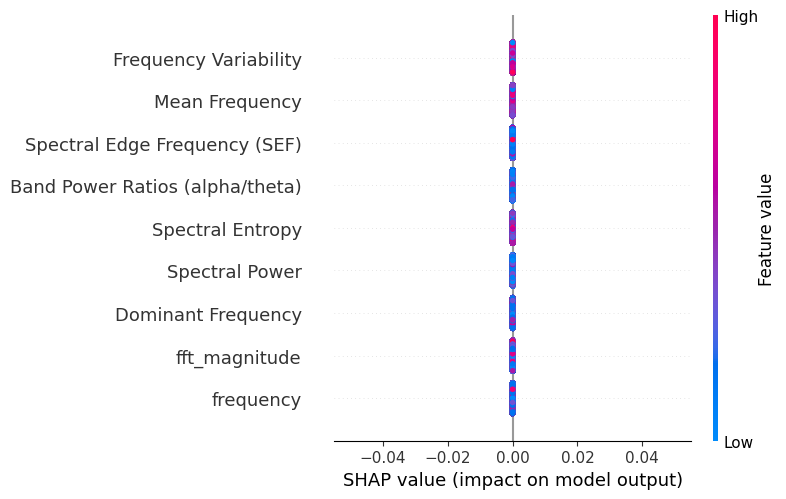

complex:
Top 3 channels (indices): [6 7 8]
Top 3 channel importance: [0. 0. 0.]



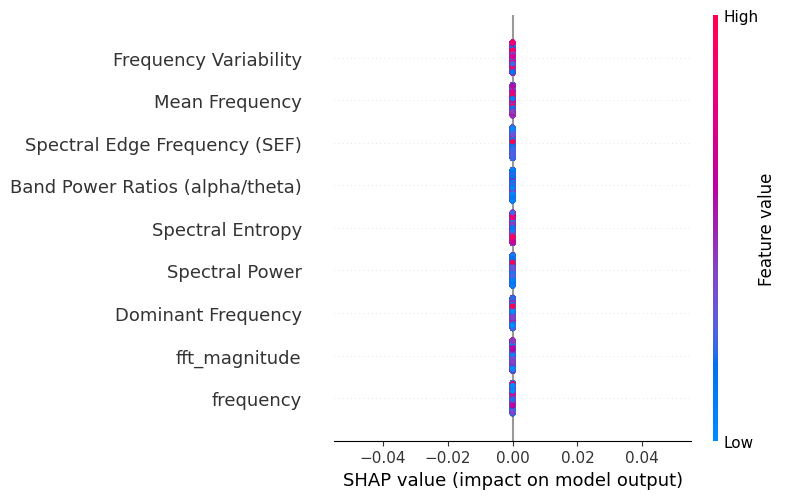

electro:
Top 3 channels (indices): [6 7 8]
Top 3 channel importance: [0. 0. 0.]



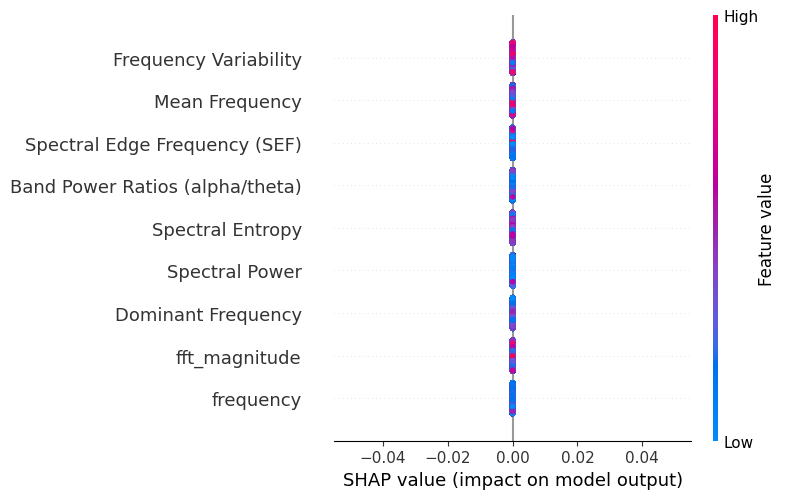

normal:
Top 3 channels (indices): [6 7 8]
Top 3 channel importance: [0. 0. 0.]



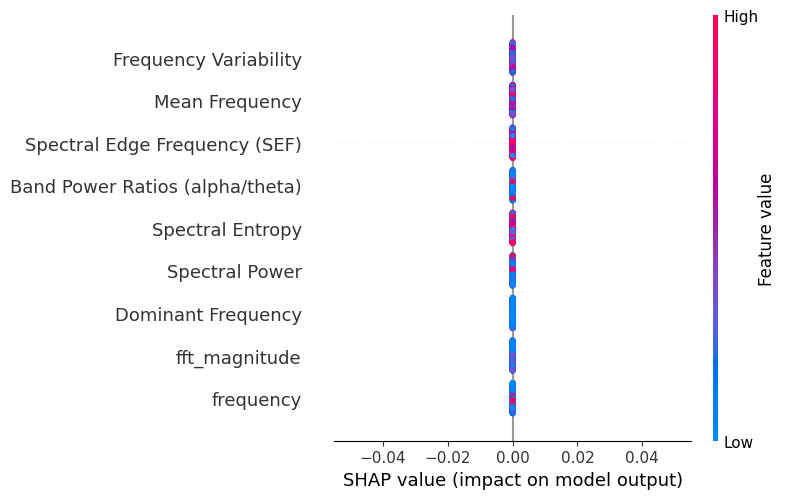

video:
Top 3 channels (indices): [6 7 8]
Top 3 channel importance: [0. 0. 0.]



In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt

# Function to load data from CSV and ensure 'label' column exists
def load_data(file_path, label):
    data = pd.read_csv(file_path)
    # Add the label column based on the sequence
    data['label'] = label
    return data

# Function to normalize the data using robust scaler
def normalize_data(data):
    scaler = RobustScaler()
    return scaler.fit_transform(data)

# List of file paths for the 4 classes
file_paths = ["/content/complex.csv", "/content/electro.csv", "/content/normal.csv", "/content/video.csv"]

# Labels for each class based on sequence, for example: [0, 1, 2, 3]
labels = [1, 2, 0, 3]

# Class names for better output readability
class_names = ['complex', 'electro', 'normal', 'video']

# Loop through each class
for i, (file_path, label) in enumerate(zip(file_paths, labels)):
    # Load the data for each class and add the appropriate label
    data = load_data(file_path, label)

    # Ensure 'label' column is included and is the target variable
    if 'label' in data.columns:
        y = data['label']
    else:
        raise ValueError(f"No 'label' column found in {file_path}. Please make sure the label column is present.")

    # Separate features (excluding 'file_name', 'channel', 'label')
    X = data.drop(columns=['file_name', 'channel', 'label'])  # Remove non-feature columns

    # Normalize the feature data using RobustScaler
    X_normalized = normalize_data(X)

    # Train a RandomForestClassifier with more trees and better control over randomness
    clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, max_depth=10)
    clf.fit(X_normalized, y)

    # Use SHAP to explain the model's predictions
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_normalized)

    # For multi-class, shap_values will be a list, so we consider the SHAP values for each class
    if isinstance(shap_values, list):
        for j, class_shap_values in enumerate(shap_values):
            # Use class names instead of generic "Class X"
            print(f"{class_names[j]}:")
            # Summing absolute SHAP values across all samples for each feature (channel)
            feature_importance = np.abs(class_shap_values).mean(axis=0)

            # Plot SHAP values for better visualization
            shap.summary_plot(class_shap_values, X_normalized, feature_names=X.columns)

            # Get the top 3 important channels based on feature importance
            top_channels_idx = np.argsort(feature_importance)[-3:]  # Top 3 channels

            # Print top 3 channels for this class
            print("Top 3 channels (indices):", top_channels_idx)
            print("Top 3 channel importance:", feature_importance[top_channels_idx])
            print()

    else:
        # For binary classification, shap_values will be a single array
        feature_importance = np.abs(shap_values).mean(axis=0)

        # Plot SHAP values for better visualization
        shap.summary_plot(shap_values, X_normalized, feature_names=X.columns)

        # Get the top 3 important channels based on feature importance
        top_channels_idx = np.argsort(feature_importance)[-3:]  # Top 3 channels

        # Print top 3 channels for this class
        print(f"{class_names[i]}:")
        print("Top 3 channels (indices):", top_channels_idx)
        print("Top 3 channel importance:", feature_importance[top_channels_idx])
        print()
